# Parameter Sweep: Effect of $p$ on Forest-Fire CA Model

This notebook explores how the tree growth probability $p$ affects the forest-fire model. Results are saved to `data/raw/p_sweep` for persistence.

In [1]:
import os, multiprocessing, csv, json, re
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import data, results
from scripts.parallel_sims import worker

## Configuration & Setup

In [2]:
# Setup output directory in data/raw
base_dir = data.path("raw/p_sweep")
base_dir.mkdir(parents=True, exist_ok=True)

idx = 1
while (base_dir / f"experiment_{idx}").exists(): idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True)
print(f"Saving to: {outdir}")

# Parameters: Larger spread for p
L, steps, f = 128, 5000, 0.0001
p_values = np.logspace(-4, -1, 7) # From 0.0001 to 0.1
replicates = 5

param_list = [
    {'L': L, 'p': p, 'f': f, 'steps': steps, 'param_id': i+1, 'run_id': j+1}
    for i, p in enumerate(p_values) for j in range(replicates)
]
print(f"Total runs: {len(param_list)}")

Saving to: /Users/andrew/Desktop/Computational Science/ComplexSystems/wildfires/data/raw/p_sweep/experiment_1
Total runs: 35


## Execution
Running simulations in parallel and saving raw results to JSON.

In [3]:
max_workers = int(os.environ.get('MAX_WORKERS', multiprocessing.cpu_count()))
all_results = []

with ProcessPoolExecutor(max_workers=max_workers) as exe:
    futures = {exe.submit(worker, outdir, p): p for p in param_list}
    for fut in as_completed(futures):
        try:
            res = fut.result()
            all_results.append(res)
            print(f"Done: p={res['p']:.4f}, fires={res['num_fires']}")
        except Exception as e: print(f"Error: {e}")

# Save raw aggregated results as JSON
raw_data_path = outdir / "raw_results.json"
with open(raw_data_path, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"Raw data saved to {raw_data_path}")

Done: p=0.0001, fires=1261
Done: p=0.0001, fires=1248
Done: p=0.0001, fires=1271
Done: p=0.0001, fires=1269
Done: p=0.0001, fires=1298
Done: p=0.0003, fires=2031
Done: p=0.0003, fires=2002
Done: p=0.0003, fires=2076
Done: p=0.0003, fires=2087
Done: p=0.0003, fires=2066
Done: p=0.0010, fires=2635
Done: p=0.0010, fires=2557
Done: p=0.0010, fires=2638
Done: p=0.0010, fires=2600
Done: p=0.0010, fires=2581
Done: p=0.0032, fires=2910
Done: p=0.0032, fires=2963
Done: p=0.0032, fires=2991
Done: p=0.0032, fires=2975
Done: p=0.0032, fires=2999
Done: p=0.0100, fires=3132
Done: p=0.0100, fires=3106
Done: p=0.0100, fires=3210
Done: p=0.0100, fires=3087
Done: p=0.0100, fires=3296
Done: p=0.0316, fires=3310
Done: p=0.0316, fires=3321
Done: p=0.0316, fires=3360
Done: p=0.0316, fires=3328
Done: p=0.0316, fires=3307
Done: p=0.1000, fires=3379
Done: p=0.1000, fires=3427
Done: p=0.1000, fires=3454
Done: p=0.1000, fires=3435
Done: p=0.1000, fires=3524
Raw data saved to /Users/andrew/Desktop/Computational S

## Analysis & Visualization

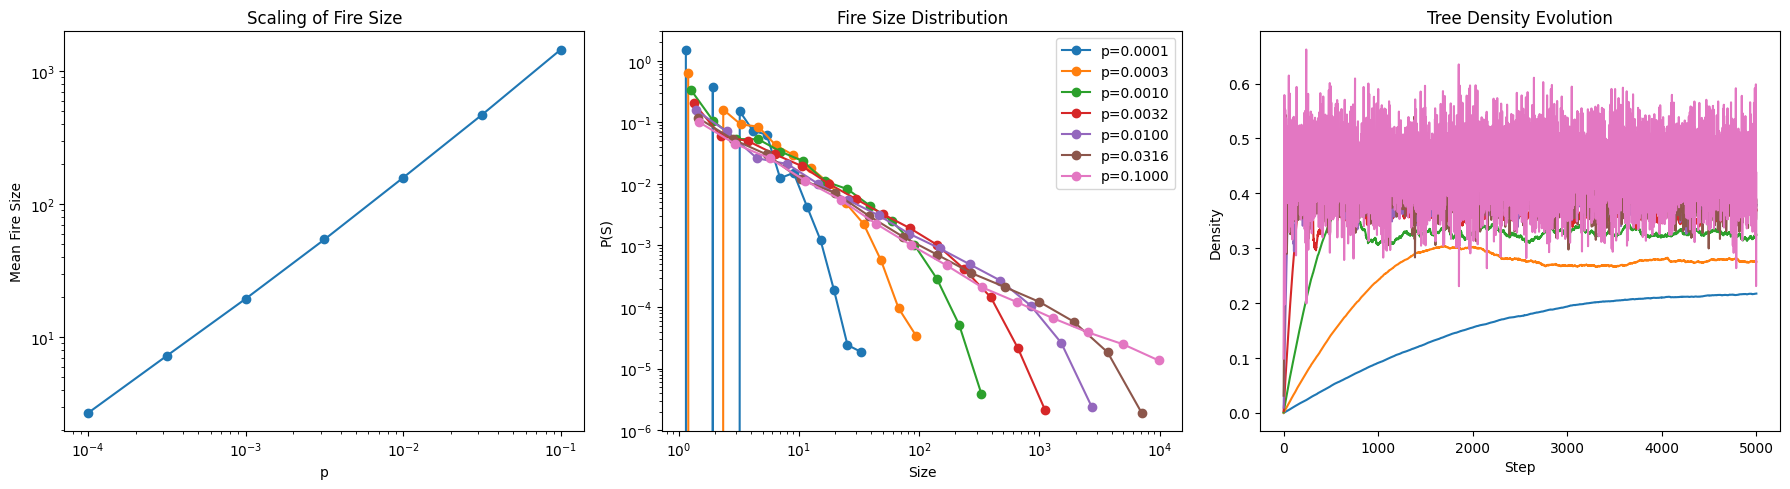

In [4]:
def load_series(fp):
    with open(fp) as f:
        reader = csv.DictReader(f)
        return [{'fires': json.loads(r['fire_size']), 'density': float(r['mean tree density'])} for r in reader]

stats = {}
for res in all_results:
    pid = res['param_id']
    if pid not in stats: stats[pid] = {'p': res['p'], 'means': [], 'densities': [], 'all_fires': []}
    
    recs = load_series(res['perstep_file'])
    run_fires = [f for r in recs for f in r['fires']]
    stats[pid]['means'].append(np.mean(run_fires) if run_fires else 0)
    stats[pid]['all_fires'].extend(run_fires)
    stats[pid]['densities'].append([r['density'] for r in recs])

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sorted_pids = sorted(stats.keys())

# 1. Mean Fire Size vs p
ps = [stats[pid]['p'] for pid in sorted_pids]
m_sizes = [np.mean(stats[pid]['means']) for pid in sorted_pids]
axes[0].loglog(ps, m_sizes, 'o-')
axes[0].set(xlabel='p', ylabel='Mean Fire Size', title='Scaling of Fire Size')

# 2. Distribution
for pid in sorted_pids:
    fires = stats[pid]['all_fires']
    if not fires: continue
    counts, bins = np.histogram(fires, bins=np.logspace(0, np.log10(max(fires)), 15), density=True)
    axes[1].loglog((bins[:-1]+bins[1:])/2, counts, 'o-', label=f"p={stats[pid]['p']:.4f}")
axes[1].set(xlabel='Size', ylabel='P(S)', title='Fire Size Distribution')
axes[1].legend()

# 3. Density
for pid in sorted_pids:
    avg_density = np.mean(stats[pid]['densities'], axis=0)
    axes[2].plot(avg_density, label=f"p={stats[pid]['p']:.4f}")
axes[2].set(xlabel='Step', ylabel='Density', title='Tree Density Evolution')

plt.tight_layout()
plt.savefig(results.path('p_sweep_analysis.png'))
plt.show()